In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm
from config import model_config
from regression import reg

from sklearn.ensemble import (
	RandomForestClassifier, AdaBoostClassifier,
	GradientBoostingClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold,
	RepeatedStratifiedKFold, RepeatedKFold
)

import xgboost as xgb

In [3]:
SEED = 123
TEST_SIZE = 0.25
CV_FOLDS = 10

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)

In [15]:
with open(Path('../data/classification_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = np.array(data.get('y')).ravel()
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)
print(y.shape)
print(body_features)
print(cardio_features)

y[:3]

(42, 21)
(42,)
['density_visceral_fat', 'mass_visceral_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'density_bone', 'mass_bone', 'bmi']
['emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']


array([1., 0., 0.])

In [68]:
X.columns

Index(['density_visceral_fat', 'mass_visceral_fat', 'volume_intermuscular_fat',
       'density_intermuscular_fat', 'density_bone', 'mass_bone', 'bmi',
       'emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume',
       'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5',
       'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio',
       'ild_volume', 'age', 'gender_cl_Male'],
      dtype='object')

In [174]:
def k_fold_cv(model, param_name, param_iter, features):
	train_auc_scores = list()
	cv_auc_scores = list()
	cv_auc_stds = list()

	for i, n in enumerate(tqdm(param_iter)):
		X_temp = X.loc[:, features]
		model.set_params(**{param_name: n})
		
		# Generate CV scores
		cv_scores = cross_val_score(model, X_temp, y, scoring='roc_auc', cv=5, n_jobs=-1)
		cv_auc_scores.append(np.mean(cv_scores))
		cv_auc_stds.append(np.std(cv_scores))

		# Generate train scores
		model.fit(X_temp, y)
		train_auc_scores.append(roc_auc_score(y, model.predict(X_temp)))
		
	return train_auc_scores, cv_auc_scores, cv_auc_stds

def repeated_k_fold_cv(model, param_name, param_iter, features):
	train_auc_scores = list()
	cv_auc_scores = list()
	cv_auc_stds = list()

	for i, n in enumerate(tqdm(param_iter)):
		X_temp = X.loc[:, features]
		model.set_params(**{param_name: n})

		rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
		cv_scores = list()
		for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
			model.fit(X_temp.iloc[train_index, :], y[train_index])
			cv_scores.append(roc_auc_score(y[test_index], model.predict(X_temp.iloc[test_index, :])))

		# Generate CV scores
		cv_auc_scores.append(np.mean(cv_scores))
		cv_auc_stds.append(np.std(cv_scores))

		# Generate train scores
		model.fit(X_temp, y)
		train_auc_scores.append(roc_auc_score(y, model.predict(X_temp)))
		
	return train_auc_scores, cv_auc_scores, cv_auc_stds

def plot_cv_scores(param_iter, train_scores, cv_scores, cv_stds):
	fig, axs = plt.subplots()

	plt.plot(param_iter, train_scores, label='train', color='blue')
	plt.plot(param_iter, cv_scores, label='cv', color='red')

	upper_ci = [mean + 1.96 * std for mean, std in zip(cv_scores, cv_stds)]
	lower_ci = [mean - 1.96 * std for mean, std in zip(cv_scores, cv_stds)]
	plt.fill_between(param_iter, lower_ci, upper_ci, alpha=0.3, label='CV ci', color='red', edgecolor=None)

	plt.xlabel('n estimators')

	plt.legend()
	plt.show()

# AdaBoost

In [16]:
adaboost = AdaBoostClassifier(random_state=SEED)
adaboost.fit(X, y)
train_auc = roc_auc_score(y, adaboost.predict(X))
cv_auc = np.mean(cross_val_score(adaboost, X, y, scoring='roc_auc', cv=10))
print(train_auc, cv_auc)


1.0 0.6


## K-Fold CV

In [180]:
n_estimators = 500
step = 10
estimators_iter = np.arange(5, n_estimators + 1, step)

train_auc_scores, cv_auc_scores, cv_auc_stds = k_fold_cv(
	AdaBoostClassifier(random_state=SEED),
	param_name='n_estimators',
	param_iter=estimators_iter,
	features=cardio_features
)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


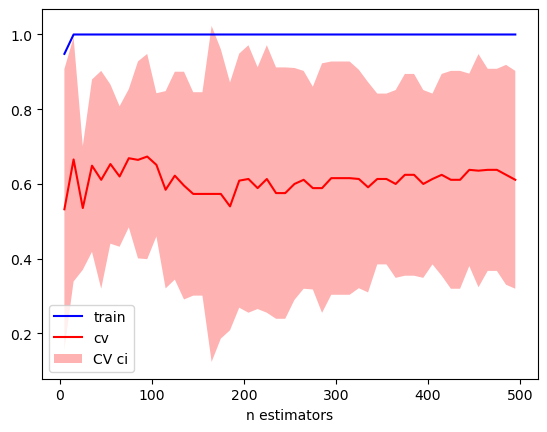

In [181]:
plot_cv_scores(estimators_iter, train_auc_scores, cv_auc_scores, cv_auc_stds)

## Repeated Stratified K-Fold CV

In [152]:
n_estimators = 100
step = 5
estimators_iter = np.arange(5, n_estimators + 1, step)

train_auc_scores, cv_auc_scores, cv_auc_stds = repeated_k_fold_cv(
	AdaBoostClassifier(random_state=SEED),
	param_name='n_estimators',
	param_iter=estimators_iter,
	features=cardio_features
)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


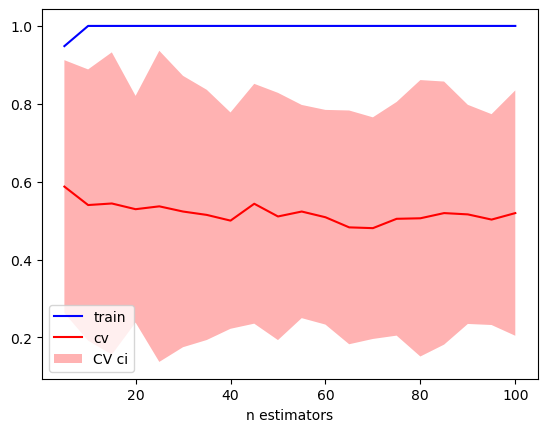

In [176]:
plot_cv_scores(estimators_iter, train_auc_scores, cv_auc_scores, cv_auc_stds)

# Random Forest

## K-Fold CV

In [178]:
n_estimators = 200
step = 5
estimators_iter = np.arange(5, n_estimators + 1, step)

train_auc_scores, cv_auc_scores, cv_auc_stds = k_fold_cv(
	RandomForestClassifier(random_state=SEED),
	param_name='n_estimators',
	param_iter=estimators_iter,
	features=cardio_features
)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.01it/s]


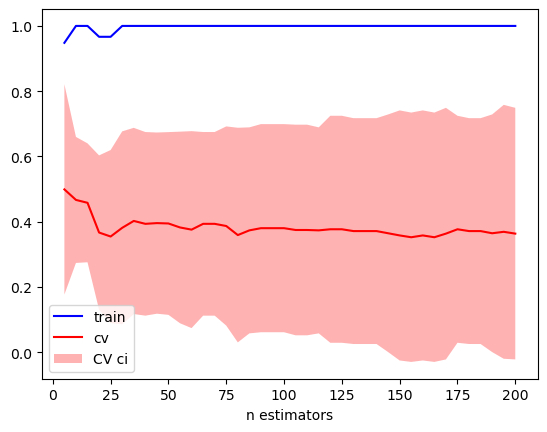

In [179]:
plot_cv_scores(estimators_iter, train_auc_scores, cv_auc_scores, cv_auc_stds)

## Repeated Stratified K-Fold CV